# `Modeling`



In [121]:
#pip install xgboost

In [122]:
# Import necessary libraries
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.combine import SMOTETomek
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random 


In [123]:
provider = pd.read_csv('provider.csv')
provider.drop(provider.columns[0], axis=1, inplace=True)
provider.head()

,Provider,inp_out,inp_out.1,ClmAdmitDiagnosisCode,DiagnosisGroupCode,AttendingPhysician,OperatingPhysician,OtherPhysician,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,settlement_days.1,Days_Admit,Total_deductible,Total_deductible.1,Total_reimbursible,Total_reimbursible.1,ClaimID,State,County,PotentialFraud
0,PRV51001,20,5,11,5,14,5,8,15,19,...,0,1.000000,1361.040000,34026,20221.200000,505530,25,1,7,0
1,PRV51003,70,62,58,58,44,7,22,56,80,...,0,2.424242,1668.545455,220248,10246.363636,1352520,132,3,23,1
2,PRV51004,149,0,25,0,38,19,26,64,88,...,0,0.000000,1057.704698,157598,6546.778523,975470,149,9,28,0
3,PRV51005,1164,0,158,0,6,6,4,426,679,...,0,0.000000,1013.544674,1179766,5531.168385,6438280,1165,4,26,1
4,PRV51007,69,3,17,3,10,5,7,26,40,...,0,0.222222,914.722222,65860,4779.722222,344140,72,2,6,0


 Train-Test Split for Potential Fraud Prediction

In [124]:

# Perform train-test split for potential fraud prediction
X = provider.drop(columns = ['PotentialFraud', 'Provider'], axis = 1)
y = provider['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4057, 39)
X_test shape: (1353, 39)
y_train shape: (4057,)
y_test shape: (1353,)


Creating functions 


In [125]:
def create_model(X_train, y_train, X_test, classifier):
    """Function that takes in the data, creates the model using the classifier, and performs prediction"""
    # Instantiate the model
    model = classifier 
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    return model, y_pred

In [126]:
#function for evaluation metrics 
def evaluation(y_test, y_pred):
    """
    A function to print evaluation metrics and classification report of a model
    """
    auc = roc_auc_score(y_test, y_pred)
    print(f"The model has an AUC score of {auc:.2%}")
    print("-----------------------------------------------")
    print(f"The model's recall rate is {recall_score(y_test, y_pred, average='weighted'):.2%}")
    print("-----------------------------------------------")
    print(f"The model's precision is {precision_score(y_test, y_pred, average='weighted'):.2%}")
    print("-----------------------------------------------")
    print(f"The model's F1 score is {f1_score(y_test, y_pred, average='weighted'):.2%}")
    print("-----------------------------------------------")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

In [127]:
def display_confusion_matrix(y_test, y_pred, cmap='GnBu'):
    """Display confusion matrix"""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['not_fraud', 'fraud'],
           yticklabels=['not_fraud', 'fraud'],
           xlabel='Predicted label',
           ylabel='True label',
           title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = '.4g'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "darkblue")
    ax.grid(False)
    fig.tight_layout()
    plt.show()

In [128]:
def plot_roc_curve(model, X_test, y_test):
    """Plot ROC curve for a binary classification model"""
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]  # Use predict_proba if available
    else:
        y_score = model.decision_function(X_test)  # Use decision_function as an alternative
    
    # Calculate False Positive Rate (FPR) and True Positive Rate (TPR) using roc_curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

## `Baseline Model`

#### Building a random model

In [129]:
train_data_len = X_train.shape[0]

# Define the list of possible output values
op_list = [0, 1]

# Initialize an array to store the predicted values
train_predicted_y = np.zeros(train_data_len)

# Generate random predictions for the training set
for i in range(train_data_len):
    train_predicted_y[i] = random.choice(op_list)

# Evaluate the performance of the random model on the training set
train_accuracy = np.mean(train_predicted_y == y_train)
print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))

# Generate random predictions for the test set
test_data_len = X_test.shape[0]
test_predicted_y = np.zeros(test_data_len)
for i in range(test_data_len):
    test_predicted_y[i] = random.choice(op_list)

# Evaluate the performance of the random model on the test set
test_accuracy = np.mean(test_predicted_y == y_test)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Training Accuracy: 50.51%
Test Accuracy: 50.85%


### `Checking and Handling Class Imbalance`

#### Sampling Techniques 

- Undersampling technique

- oversampling technique

- Hybrid sampling technique

In [130]:
# undersampling technique
from imblearn.under_sampling import NearMiss
from collections import Counter

# Create an instance of NearMiss with a sampling ratio of 0.8
ns = NearMiss(sampling_strategy=0.8)

# Apply undersampling to the training data
x_train_ns, y_train_ns = ns.fit_resample(X_train, y_train)

# Print the class distribution before and after undersampling
print("The number of classes before fit: {}".format(Counter(y_train)))
print("The number of classes after fit: {}".format(Counter(y_train_ns)))


The number of classes before fit: Counter({0: 3680, 1: 377})
The number of classes after fit: Counter({0: 471, 1: 377})


`Decision Tree with undersampling`

In [131]:
model, y_pred = create_model(x_train_ns, y_train_ns, X_test, classifier=DecisionTreeClassifier(random_state=42))


In [132]:
evaluation(y_test, y_pred)

The model has an AUC score of 64.86%
-----------------------------------------------
The model's recall rate is 47.08%
-----------------------------------------------
The model's precision is 88.94%
-----------------------------------------------
The model's F1 score is 56.06%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.43      0.59      1224
           1       0.14      0.87      0.24       129

    accuracy                           0.47      1353
   macro avg       0.55      0.65      0.42      1353
weighted avg       0.89      0.47      0.56      1353



`Random Forest with undersampling`

In [133]:
model, y_pred = create_model(x_train_ns, y_train_ns, X_test, classifier=RandomForestClassifier(random_state=42))


In [134]:
evaluation(y_test, y_pred)

The model has an AUC score of 68.06%
-----------------------------------------------
The model's recall rate is 52.25%
-----------------------------------------------
The model's precision is 89.54%
-----------------------------------------------
The model's F1 score is 61.07%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.49      0.65      1224
           1       0.15      0.88      0.26       129

    accuracy                           0.52      1353
   macro avg       0.56      0.68      0.45      1353
weighted avg       0.90      0.52      0.61      1353



In [135]:
# oversampling technique

from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# Assuming X_train and y_train are defined and assigned values correctly

os = RandomOverSampler(sampling_strategy=0.75)
x_train_os, y_train_os = os.fit_resample(X_train, y_train)

print("The number of classes before fit: {}".format(Counter(y_train)))
print("The number of classes after fit: {}".format(Counter(y_train_os)))


The number of classes before fit: Counter({0: 3680, 1: 377})
The number of classes after fit: Counter({0: 3680, 1: 2760})


`Decision tree with oversampling technique`

In [136]:
model, y_pred = create_model(x_train_os, y_train_os, X_test, classifier=DecisionTreeClassifier(random_state=42))


In [137]:
evaluation(y_test, y_pred)

The model has an AUC score of 69.03%
-----------------------------------------------
The model's recall rate is 90.39%
-----------------------------------------------
The model's precision is 89.80%
-----------------------------------------------
The model's F1 score is 90.07%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1224
           1       0.50      0.43      0.46       129

    accuracy                           0.90      1353
   macro avg       0.72      0.69      0.70      1353
weighted avg       0.90      0.90      0.90      1353



`random forest with over sampling technique`

In [138]:
model, y_pred = create_model(x_train_os, y_train_os, X_test, classifier=RandomForestClassifier(random_state=42))


In [139]:
evaluation(y_test, y_pred)

The model has an AUC score of 72.91%
-----------------------------------------------
The model's recall rate is 92.39%
-----------------------------------------------
The model's precision is 91.71%
-----------------------------------------------
The model's F1 score is 91.95%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1224
           1       0.63      0.49      0.55       129

    accuracy                           0.92      1353
   macro avg       0.79      0.73      0.75      1353
weighted avg       0.92      0.92      0.92      1353



`Hybrid sampling technique`

In [140]:
st = SMOTETomek()
x_train_st, y_train_st = st.fit_resample(X_train, y_train)

print("The number of classes before fit: {}".format(Counter(y_train)))
print("The number of classes after fit: {}".format(Counter(y_train_st)))

The number of classes before fit: Counter({0: 3680, 1: 377})
The number of classes after fit: Counter({0: 3608, 1: 3608})


`Decision tree Hybrid sampling technique`

In [141]:
model, y_pred = create_model(x_train_st, y_train_st, X_test, classifier=DecisionTreeClassifier(random_state=42))


In [142]:
evaluation(y_test, y_pred)

The model has an AUC score of 74.29%
-----------------------------------------------
The model's recall rate is 87.36%
-----------------------------------------------
The model's precision is 89.98%
-----------------------------------------------
The model's F1 score is 88.43%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      1224
           1       0.39      0.58      0.47       129

    accuracy                           0.87      1353
   macro avg       0.67      0.74      0.70      1353
weighted avg       0.90      0.87      0.88      1353



`Random Forest hybrid sampling technique`

In [143]:
model, y_pred = create_model(x_train_st, y_train_st, X_test, classifier=RandomForestClassifier(random_state=42))


In [144]:
evaluation(y_test, y_pred)

The model has an AUC score of 79.66%
-----------------------------------------------
The model's recall rate is 90.17%
-----------------------------------------------
The model's precision is 91.82%
-----------------------------------------------
The model's F1 score is 90.83%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1224
           1       0.49      0.67      0.56       129

    accuracy                           0.90      1353
   macro avg       0.73      0.80      0.75      1353
weighted avg       0.92      0.90      0.91      1353



Scaling the Numerical Features 


In [145]:
from sklearn.preprocessing import StandardScaler

# Instantiate the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(x_train_st)
X_test_scaled = scaler.transform(X_test)

## 2. `Gradientboost model`

In [146]:
model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=GradientBoostingClassifier(random_state=42))


In [147]:
evaluation(y_test, y_pred)

The model has an AUC score of 84.10%
-----------------------------------------------
The model's recall rate is 88.17%
-----------------------------------------------
The model's precision is 92.42%
-----------------------------------------------
The model's F1 score is 89.63%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1224
           1       0.43      0.79      0.56       129

    accuracy                           0.88      1353
   macro avg       0.70      0.84      0.75      1353
weighted avg       0.92      0.88      0.90      1353



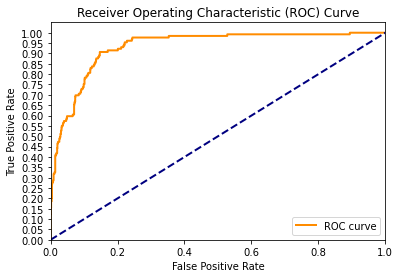

In [148]:
plot_roc_curve(model, X_test_scaled, y_test)

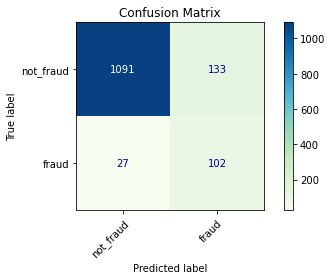

In [149]:
display_confusion_matrix(y_test, y_pred)

## 3. `Decision tree Model`

In [150]:
model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=DecisionTreeClassifier(random_state=42))


In [151]:
evaluation(y_test, y_pred)

The model has an AUC score of 74.33%
-----------------------------------------------
The model's recall rate is 87.44%
-----------------------------------------------
The model's precision is 90.01%
-----------------------------------------------
The model's F1 score is 88.49%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1224
           1       0.39      0.58      0.47       129

    accuracy                           0.87      1353
   macro avg       0.67      0.74      0.70      1353
weighted avg       0.90      0.87      0.88      1353



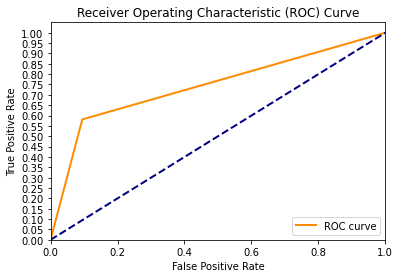

In [152]:
plot_roc_curve(model, X_test_scaled, y_test)

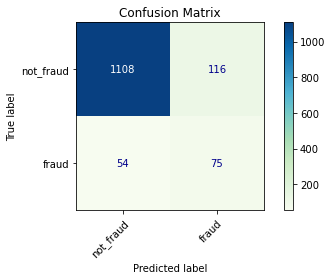

In [153]:

display_confusion_matrix(y_test, y_pred)

## 4. `Random Forest Model`

In [154]:
model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=RandomForestClassifier(random_state=42))


In [155]:
evaluation(y_test, y_pred)

The model has an AUC score of 79.62%
-----------------------------------------------
The model's recall rate is 90.10%
-----------------------------------------------
The model's precision is 91.79%
-----------------------------------------------
The model's F1 score is 90.77%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1224
           1       0.49      0.67      0.56       129

    accuracy                           0.90      1353
   macro avg       0.72      0.80      0.75      1353
weighted avg       0.92      0.90      0.91      1353



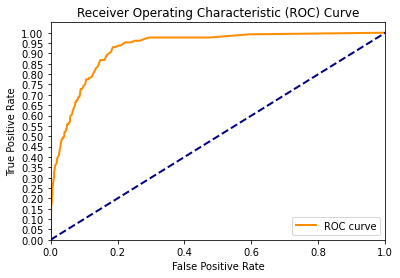

In [156]:
plot_roc_curve(model, X_test_scaled, y_test)

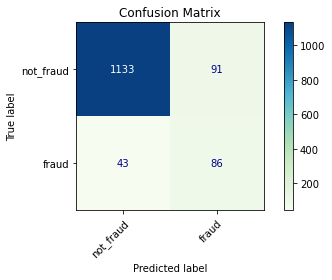

In [157]:
display_confusion_matrix(y_test, y_pred)

## 5. `SVM`

In [158]:
model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=SVC(random_state=42))


In [159]:
evaluation(y_test, y_pred)

The model has an AUC score of 85.30%
-----------------------------------------------
The model's recall rate is 87.21%
-----------------------------------------------
The model's precision is 92.60%
-----------------------------------------------
The model's F1 score is 88.99%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1224
           1       0.41      0.83      0.55       129

    accuracy                           0.87      1353
   macro avg       0.70      0.85      0.74      1353
weighted avg       0.93      0.87      0.89      1353



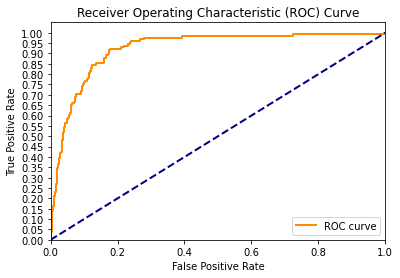

In [160]:
plot_roc_curve(model, X_test_scaled, y_test)

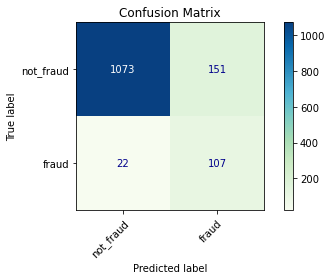

In [161]:
display_confusion_matrix(y_test, y_pred)

## 6. `XGBoost`

In [162]:
model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=XGBClassifier(random_state=42))

In [163]:
evaluation(y_test, y_pred)

The model has an AUC score of 79.29%
-----------------------------------------------
The model's recall rate is 90.76%
-----------------------------------------------
The model's precision is 91.93%
-----------------------------------------------
The model's F1 score is 91.25%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1224
           1       0.51      0.65      0.57       129

    accuracy                           0.91      1353
   macro avg       0.74      0.79      0.76      1353
weighted avg       0.92      0.91      0.91      1353



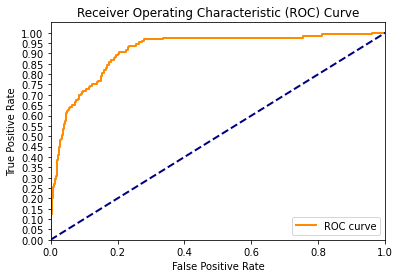

In [164]:
plot_roc_curve(model, X_test_scaled, y_test)

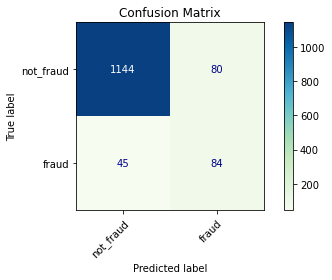

In [165]:
display_confusion_matrix(y_test, y_pred)

## 7. `KNN`

In [166]:
model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=KNeighborsClassifier())

In [167]:
evaluation(y_test, y_pred)

The model has an AUC score of 81.33%
-----------------------------------------------
The model's recall rate is 84.41%
-----------------------------------------------
The model's precision is 91.40%
-----------------------------------------------
The model's F1 score is 86.79%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      1224
           1       0.35      0.78      0.49       129

    accuracy                           0.84      1353
   macro avg       0.66      0.81      0.70      1353
weighted avg       0.91      0.84      0.87      1353



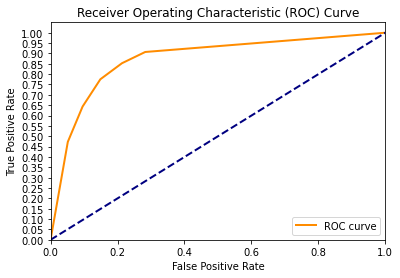

In [168]:
plot_roc_curve(model, X_test_scaled, y_test)

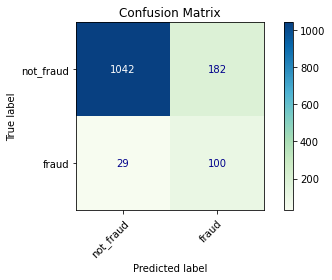

In [169]:
display_confusion_matrix(y_test, y_pred)